In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from numpy import load
import time
import math
import re

In [ ]:
class input:
    def __init__(self):
        self.next_layers = []
        self.output = None
        self.dX = None
    
    def propagate(self, X):
        self.output = X
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = Y


def activate(X, function):
    if function == 'leakyReLu':
        for k in X:
            for i in k:
                for j in i:
                    if j < 0:
                        j = 0.05 * j
    elif function == 'sigmoid':
        if X > 709:
            X = 709
        if X < -709:
            X = -709
        X = 1 / (1 + math.exp(-X))
    elif function == 'tanh':
        X = np.tanh(X)
    return X


def derivative(Y, function):
    if function == 'leakyReLu':
        pass
    elif function == 'sigmoid':
        if Y > 709:
            Y = 709
        if Y < -709:
            Y = -709
        Y = 1 / (1 + math.exp(-Y))
        Y = Y*(1-Y)
    elif function == 'tanh':
        Y = 1 - np.tanh(Y)**2
    return Y


class conv2d:
    def __init__(self, channels, kernel_dims, strides, pre_layer, activation='leakyReLU'):
        self.kernels = np.random.rand(channels, kernel_dims[0], kernel_dims[1], kernel_dims[2])
        self.pre_layer = pre_layer
        self.next_layers = []
        self.strides = strides
        self.activation = activation
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        dims = (X.shape)
        kernels_dims = self.kernels.shape
        pad_x = int(kernels_dims[2] / 2)
        pad_y = int(kernels_dims[3] / 2)
        x_seg = int(dims[1] / self.strides[0])
        y_seg = int(dims[2] / self.strides[1])
        X = np.pad(X, ((0, 0), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=0)
        Y = cp.zeros([kernels_dims[0], x_seg, y_seg])
        arr = np.zeros([x_seg*y_seg, kernels_dims[1], kernels_dims[2], kernels_dims[3]])
        t = 0
        for i in range(0, dims[2], self.strides[1]):
            for j in range(0, dims[1], self.strides[0]):
                arr[t] = X[:, i:i+kernels_dims[2], j:j+kernels_dims[3]]
                t += 1
        arr = cp.array(arr)
        arr = cp.reshape(arr, (1, x_seg*y_seg, kernels_dims[1], kernels_dims[2], kernels_dims[3]))
        kernels = cp.reshape(cp.array(self.kernels), (kernels_dims[0], 1, kernels_dims[1], kernels_dims[2], kernels_dims[3]))
        arr = arr * kernels
        arr = cp.sum(arr, (2,3,4))
        t = 0
        for i in range(0, y_seg):
            for j in range(0, x_seg):
                Y[:,i,j] = arr[:, t]
                t += 1
        Y = cp.asnumpy(Y)
        self.output = activate(Y, self.activation)
    
    def back_propagate(self, Y, l_rate, learn=True):
        Y = derivative(Y, self.activation)
        X = self.pre_layer.output
        dims = (X.shape)
        kernels_dims = self.kernels.shape
        pad_x = int(kernels_dims[2] / 2)
        pad_y = int(kernels_dims[3] / 2)
        x_seg = int(dims[1] / self.strides[0])
        y_seg = int(dims[2] / self.strides[1])
        X = np.pad(X, ((0, 0), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=0)
        if self.strides[0] == 1:
            kernels = cp.rot90(cp.array(self.kernels), 2, (2,3))
            Y = np.pad(Y, ((0, 0), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=0)
            arr = np.zeros([x_seg*y_seg, kernels_dims[0], kernels_dims[2], kernels_dims[3]])
            t = 0
            for i in range(0, y_seg):
                for j in range(0, x_seg):
                    arr[t] = Y[:, i:i+kernels_dims[2], j:j+kernels_dims[3]]
                    t += 1
            arr = np.reshape(arr, (arr.shape[0], arr.shape[1], 1, arr.shape[2], arr.shape[3]))
        else:
            kernels = cp.array(self.kernels)
            arr = np.zeros([x_seg*y_seg, kernels_dims[0]])
            t = 0
            for i in range(0, y_seg):
                for j in range(0, x_seg):
                    arr[t] = Y[:, i, j]
                    t += 1
            arr = np.reshape(arr, (arr.shape[0], arr.shape[1], 1, 1, 1))
        arr = cp.array(arr)
        if learn:
            if self.strides[0] == 1:
                Y = Y[:, pad_x:-pad_x, pad_y:-pad_y]
                Y = cp.array(Y)
                arr2 = np.zeros([kernels_dims[2] * kernels_dims[3], kernels_dims[1], dims[1], dims[2]])
                t = 0
                for i in range(0, kernels_dims[3]):
                    for j in range(0, kernels_dims[2]):
                        arr2[t] = X[:, i:i+dims[1], j:j+dims[2]]
                        t += 1
                arr2 = cp.array(arr2)
                arr2 = cp.reshape(arr2, (arr2.shape[0], arr2.shape[1], 1, arr2.shape[2], arr2.shape[3]))
                dW = cp.sum(Y * arr2, (3, 4))
                dW = cp.transpose(dW, (2, 1, 0))
                dW = cp.reshape(dW, (kernels_dims[0], kernels_dims[1], kernels_dims[2], kernels_dims[3]))
            else:
                arr2 = np.zeros([x_seg*y_seg, kernels_dims[1], kernels_dims[2], kernels_dims[3]])
                t = 0
                for i in range(0, dims[2], self.strides[1]):
                    for j in range(0, dims[1], self.strides[0]):
                        arr2[t] = X[:, i:i+kernels_dims[2], j:j+kernels_dims[3]]
                        t += 1
                arr2 = cp.array(arr2)
                arr2 = cp.reshape(arr2, (arr2.shape[0], 1, arr2.shape[1], arr2.shape[2], arr2.shape[3]))
                dW = cp.sum(arr * arr2, (0))
        arr = arr * kernels
        if self.strides[0] == 1:
            arr = cp.sum(arr, (1,3,4))
            dX = cp.zeros([kernels_dims[1], dims[1], dims[2]])
            t = 0
            for i in range(0, dims[1], self.strides[1]):
                for j in range(0, dims[2], self.strides[0]):
                    dX[:,i,j] = arr[t]
                    t += 1
        else:
            arr = cp.sum(arr, (1))
            dX = cp.zeros((dims[0], dims[1]+(2*pad_x), dims[2]+(2*pad_y)))
            t = 0
            for i in range(0, dims[1], self.strides[1]):
                for j in range(0, dims[2], self.strides[0]):
                    dX[:, i:i+kernels_dims[2], j:j+kernels_dims[3]] += arr[t]
                    t += 1
            dX = dX[:, pad_x:-pad_x, pad_y:-pad_y]
        self.dX = cp.asnumpy(dX)
        if learn:
            kernels = cp.array(self.kernels)
            kernels -= cp.multiply(l_rate, dW)
            self.kernels = cp.asnumpy(kernels)


class deconv2d:
    def __init__(self, channels, kernel_dims, strides, pre_layer, activation='leakyReLU'):
        self.kernels = np.random.rand(channels, kernel_dims[0], kernel_dims[1], kernel_dims[2])
        self.pre_layer = pre_layer
        self.next_layers = []
        self.strides = strides
        self.activation = activation
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        dims = (X.shape)
        kernels_dims = self.kernels.shape
        pad_x = int(kernels_dims[2] / 2)
        pad_y = int(kernels_dims[3] / 2)
        x_seg = dims[1] * self.strides[0]
        y_seg = dims[2] * self.strides[1]
        Y = cp.zeros([kernels_dims[0], x_seg+(pad_x*2), y_seg+(pad_y*2)])
        arr = np.zeros([kernels_dims[1], dims[1]*dims[2]])
        t = 0
        for i in range(0, dims[2]):
            for j in range(0, dims[1]):
                arr[:, t] = X[:,i,j]
                t += 1
        arr = cp.array(arr)
        kernels = cp.array(self.kernels)
        arr = cp.reshape(arr, (1, arr.shape[0], arr.shape[1], 1, 1))
        kernels = cp.reshape(kernels, (kernels_dims[0], kernels_dims[1], 1, kernels_dims[2], kernels_dims[3]))
        arr = cp.sum(cp.multiply(arr, kernels), (1))
        t = 0
        for i in range(0, y_seg, self.strides[1]):
            for j in range(0, x_seg, self.strides[0]):
                Y[:, i:i+kernels_dims[2], j:j+kernels_dims[3]] += arr[:, t]
                t += 1
        Y = Y[:, pad_x:-pad_x, pad_y:-pad_y]
        Y = cp.asnumpy(Y)
        self.output = activate(Y, self.activation)
    
    def back_propagate(self, Y, l_rate, learn=True):
        Y = derivative(Y, self.activation)
        kernels = cp.rot90(cp.array(self.kernels), 2, (2,3))
        X = self.pre_layer.output
        dims = list(X.shape)
        kernels_dims = kernels.shape
        pad_x = int(kernels_dims[2] / 2)
        pad_y = int(kernels_dims[3] / 2)
        x_seg = dims[1] * self.strides[0]
        y_seg = dims[2] * self.strides[1]
        arr = np.zeros([dims[1]*dims[2], kernels_dims[0]])
        arr2 = np.zeros([dims[1]*dims[2], kernels_dims[1], kernels_dims[2], kernels_dims[3]])
        if self.strides[0] == 1:
            arr = np.zeros([dims[1]*dims[2], kernels_dims[0]])
            t = 0
            for i in range(0, y_seg, self.strides[1]):
                for j in range(0, x_seg, self.strides[0]):
                    arr[t] = Y[:,i,j]
                    t += 1
            arr = np.reshape(arr, (arr.shape[0], arr.shape[1], 1, 1, 1))
        else:
            Y = np.pad(Y, ((0, 0), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=0)
            arr = np.zeros([dims[1]*dims[2], kernels_dims[0], kernels_dims[2], kernels_dims[3]])
            t = 0
            for i in range(0, y_seg, self.strides[1]):
                for j in range(0, x_seg, self.strides[0]):
                    arr[t] = Y[:,i:i+kernels_dims[2], j:j+kernels_dims[3]]
                    t += 1
            arr = np.reshape(arr, (arr.shape[0], arr.shape[1], 1, arr.shape[2], arr.shape[3]))
        arr = cp.array(arr)
        if learn:
            if self.strides[0] == 1:
                X = np.pad(X, ((0, 0), (pad_x, pad_x), (pad_y, pad_y)), 'constant', constant_values=0)
                arr2 = np.zeros([dims[1]*dims[2], kernels_dims[1], kernels_dims[2], kernels_dims[3]])
                t = 0
                for i in range(0, dims[2]):
                    for j in range(0, dims[1]):
                        arr2[t] = X[:, i:i+kernels_dims[2], j:j+kernels_dims[3]]
                        t += 1
                arr2 = np.reshape(arr2, (arr2.shape[0], 1, arr2.shape[1], arr2.shape[2], arr2.shape[3]))
            else:
                arr2 = np.zeros([dims[1]*dims[2], kernels_dims[1]])
                t = 0
                for i in range(0, dims[2]):
                    for j in range(0, dims[1]):
                        arr2[t] = X[:, i, j]
                        t += 1
                arr2 = np.reshape(arr2, (arr2.shape[0], 1, arr2.shape[1], 1, 1))
            arr2 = cp.array(arr2)
            dW = cp.sum(cp.multiply(arr, arr2), (0))
        arr = cp.sum(cp.multiply(arr, kernels), (1))
        if self.strides[0] == 1:
            dX = cp.zeros((dims[0], dims[1]+(2*pad_x), dims[2]+(2*pad_y)))
            t = 0
            for i in range(0, dims[2]):
                for j in range(0, dims[1]):
                    dX[:, i:i+kernels_dims[2], j:j+kernels_dims[3]] += arr[t]
                    t += 1
            dX = dX[:, pad_x:-pad_x, pad_y:-pad_y]
        else:
            arr = cp.sum(arr, (2, 3))
            dX = cp.zeros((dims[0], dims[1], dims[2]))
            t = 0
            for i in range(0, dims[2]):
                for j in range(0, dims[1]):
                    dX[:, i, j] = arr[t]
                    t += 1
        self.dX = cp.asnumpy(dX)
        if learn:
            kernels = cp.array(self.kernels)
            kernels -= cp.multiply(l_rate, dW)
            self.kernels = cp.asnumpy(kernels)


class dense:
    def __init__(self, neurons, input_dims, pre_layer, end_layer=False, activation='leakyReLU', control=0):
        self.end_layer = end_layer
        self.weights = np.random.rand(neurons, input_dims)
        self.dX = np.random.rand(neurons)
        self.pre_layer = pre_layer
        self.next_layers = []
        self.activation = activation
        self.output = None
        pre_layer.next_layers.append(self)
        self.control = control
    
    def propagate(self):
        X = cp.array(self.pre_layer.output)
        weights = cp.array(self.weights)
        X = cp.reshape(X, (1, len(X)))
        Y = cp.sum(X * weights, (1))
        Y = cp.asnumpy(Y)
        self.output = activate(Y, self.activation)
        self.unactive_output = Y
    
    def back_propagate(self, Y, l_rate, learn=True):
        if self.control != 0:
            l_rate = l_rate * self.control
        X = cp.array(self.pre_layer.output)
        Y = cp.array(Y)
        unactive_output = cp.array(self.unactive_output)
        weights = cp.array(self.weights)
        
        if not self.end_layer:
            deltas = Y * derivative(unactive_output, self.activation)
            if Y.size == 1:
                dX = weights * Y
            else:
                dX = weights * cp.reshape(Y, (len(Y), 1))
            dX = cp.sum(dX, (0))
        else:
            deltas = (unactive_output - Y)
            dX = weights * cp.reshape(deltas, (len(deltas), 1))
            dX = cp.sum(dX, (0))
        
        if learn:
            if Y.size == 1:
                dW = cp.multiply(l_rate, cp.array(deltas) * cp.reshape(X, (1, len(X))))# * (10 / len(Y))
            else:
                dW = cp.multiply(l_rate, cp.reshape(cp.array(deltas), (len(Y), 1)) * cp.reshape(X, (1, len(X))))# * (10 / len(Y))
            weights -= dW
            self.weights = weights
        self.dX = cp.asnumpy(dX)


class add:
    def __init__(self, pre_layer1, pre_layer2):
        self.pre_layer1 = pre_layer1
        self.pre_layer2 = pre_layer2
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer1.next_layers.append(self)
        pre_layer2.next_layers.append(self)
    
    def propagate(self):
        X1 = self.pre_layer1.output
        X2 = self.pre_layer2.output
        self.output = X1 + X2
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = Y


class concatenate:
    def __init__(self, pre_layer1, pre_layer2):
        self.pre_layer1 = pre_layer1
        self.pre_layer2 = pre_layer2
        self.next_layers = []
        self.output = None
        self.dX = None
        self.split_point = None
        pre_layer1.next_layers.append(self)
        pre_layer2.next_layers.append(self)
    
    def propagate(self):
        X1 = self.pre_layer1.output
        X2 = self.pre_layer2.output
        self.split_point = len(X1)
        self.output = np.concatenate((X1, X2))
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = np.array_split(np.array(Y), [self.split_point])


class leakyReLU:
    def __init__(self, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        for k in X:
            for i in k:
                for j in i:
                    if j < 0:
                        j = 0.05 * j
        self.output = X
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = Y

class sigmoid:
    def __init__(self, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        if X > 709:
            X = 709
        if X < -709:
            X = -709
        X = 1 / (1 + math.exp(-X))
        self.output = X
    
    def back_propagate(self, Y, l_rate, learn):
        if Y > 709:
            Y = 709
        if Y < -709:
            Y = -709
        Y = 1 / (1 + math.exp(-Y))
        self.dX = Y*(1-Y)

class tanh:
    def __init__(self, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        self.output = np.tanh(X)
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = 1 - np.tanh(Y)**2


class softmax:
    def __init__(self, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        self.output = np.exp(X)/sum(np.exp(X))
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = Y


class flatten:
    def __init__(self, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        self.output = np.reshape(self.pre_layer.output, -1)
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = np.reshape(np.array(Y), self.pre_layer.output.shape)


class normalize:
    def __init__(self, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        X = self.pre_layer.output
        if len(X.shape) > 1:
            sums_in_rows = X.sum(axis=2)
            for i in range(len(sums_in_rows)):
                for j in range(len(sums_in_rows[0])):
                    if sums_in_rows[i,j] == 0:
                        sums_in_rows[i,j] = 1
            X = X / sums_in_rows[:, :, np.newaxis]
        else:
            sum_in_row = X.sum()
            if sum_in_row == 0:
                sum_in_row = 1
            X = X / sum_in_row
        self.output = X
    
    def back_propagate(self, Y, l_rate, learn):
        if len(Y.shape) > 1:
            for k in range(len(Y)):
                sums_in_rows = Y[k].sum(axis=1)
                for i in range(len(sums_in_rows)):
                    if sums_in_rows[i] == 0:
                        sums_in_rows[i] = 1
                Y[k] = Y[k] / sums_in_rows[:, np.newaxis]
        else:
            sum_in_row = Y.sum()
            if sum_in_row == 0:
                sum_in_row = 1
            Y = Y / sum_in_row
        self.dX = Y


class reshape:
    def __init__(self, size, pre_layer):
        self.pre_layer = pre_layer
        self.next_layers = []
        self.output = None
        self.dX = None
        self.size = size
        pre_layer.next_layers.append(self)
    
    def propagate(self):
        self.output = np.reshape(self.pre_layer.output, self.size)
    
    def back_propagate(self, Y, l_rate, learn):
        self.dX = np.reshape(Y, self.pre_layer.output.shape)
        

class neural_network:
    def __init__(self, number_of_inputs=1):
        self.layers = []
        self.number_of_inputs = number_of_inputs
        self.pre_con_idxs = [None, None]
    
    def add(self, layer):
        self.layers.append(layer)
        return layer
    
    def set_pre_con_idxs(self, idxs):
        self.pre_con_idxs = idxs
    
    def propagate(self, X1, X2=None):
        self.layers[0].propagate(X1)
        if self.number_of_inputs == 2:
            self.layers[1].propagate(X2)
        for i in range(self.number_of_inputs, len(self.layers)):
            self.layers[i].propagate()
        return self.layers[-1].output
    
    def back_propagate(self, expected, l_rate, learn=True):
        self.layers[-1].back_propagate(expected, l_rate, learn)
        for i in reversed(range(len(self.layers)-1)):
            if str(type(self.layers[i])) == '<class \'__main__.normalize\'>':
                l_rate * 2
            for x in self.layers[i].next_layers:
                if i == self.pre_con_idxs[0]:
                    self.layers[i].back_propagate(x.dX[0], l_rate, learn)
                elif i == self.pre_con_idxs[1]:
                    self.layers[i].back_propagate(x.dX[1], l_rate, learn)
                else:
                    self.layers[i].back_propagate(x.dX, l_rate, learn)
        
        if self.number_of_inputs == 2:
            return [self.layers[0].dX, self.layers[1].dX]
        else:
            return self.layers[0].dX

    def train(self, laten, expected, l_rate):
        self.propagate(laten)
        self.back_propagate(expected, l_rate)

    def save(self, path):
        for i in range(len(self.layers)):
            try:
                np.save(path + str(i), self.layers[i].kernels)
            except:
                pass
            try:
                np.save(path + str(i), self.layers[i].weights)
            except:
                pass

    def load(self, path):
        for i in range(len(self.layers)):
            try:
                self.layers[i].kernels = np.load(path + str(i) + ".npy")
            except:
                pass
            try:
                self.layers[i].weights = np.load(path + str(i) + ".npy")
            except:
                pass



In [ ]:
def count_l_rate(loss):
    l_rate = 0.001 * loss
    return l_rate

In [ ]:
class BIGAN:
    def __init__(self):
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        # Build the generator
        self.generator = self.build_generator()

    def build_generator(self):
        model = neural_network()

        y = model.add(input())
        y = model.add(dense(1600, 1, y))
        y = model.add(normalize(y))
        y = model.add(reshape((1, 40, 40), y))
        
        y = model.add(deconv2d(16, [1, 3, 3], (1, 1), y))
        y = model.add(normalize(y))
        y = model.add(flatten(y))

        y = model.add(dense(4800, 16*40*40, y, 'tanh'))
        y = model.add(reshape((40, 40, 3), y))

        print("generator")
        return model


    def build_discriminator(self):
        model = neural_network()

        inputA = model.add(input())

        # normal
        y = model.add(flatten(inputA))

        y = model.add(dense(3*800, 3*1600, y, control=0.1))
        y = model.add(normalize(y))

        y = model.add(dense(3*400, 3*800, y))
        y = model.add(normalize(y))

        y = model.add(dense(3*200, 3*400, y))
        y = model.add(normalize(y))

        z = model.add(dense(3*100, 3*200, y))
        z = model.add(normalize(z))
        z = model.add(dense(1, 3*100, z, True, 'sigmoid'))

        print("discriminator")
        return model


    def train(self, dataset, state, epochs, batch_size=100, sample_interval=50, l_rate=0.0001):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(state, epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Sample noise and generate img
            z = [1]
            imgs_ = self.generator.propagate(z)

            idx = np.random.randint(0, dataset.shape[0], 1)
            imgs = dataset[idx]

            Y1 = self.discriminator.propagate(imgs)
            dX1 = self.discriminator.back_propagate(valid, l_rate)
            Y2 = self.discriminator.propagate(imgs_)
            dX2 = self.discriminator.back_propagate(fake, l_rate)

            # ---------------------
            #  Train Generator
            # ---------------------
            Y1 = self.discriminator.propagate(imgs_)
            dX1 = self.discriminator.back_propagate(valid, l_rate, False)

            self.generator.back_propagate(dX1, l_rate)

            loss = ((1-Y1)**2 + (0-Y2)**2) / 2
            print(loss)
            print(bigan.generator.layers[-2].weights)

            l_rate = count_l_rate(loss)
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:

                print("%d" % (epoch))
                self.sample_interval(epoch)
                self.generator.save(f"./drive/MyDrive/models11/gen_{epoch}_")
                self.discriminator.save(f"./drive/MyDrive/models11/dis_{epoch}_")

    def sample_interval(self, epoch):
        z = [1]
        img = self.generator.propagate(z)
        img = img * 0.5 + 0.5

        plt.imshow(img)
        plt.savefig("./drive/MyDrive/imgs11/faces_%d.png" % epoch)


In [ ]:
dataset = load("./drive/MyDrive/dset40color.npz")
dataset = dataset["arr_0"]
dataset = (dataset.astype(np.float32) - 127.5) / 127.5

In [ ]:
bigan = BIGAN()

discriminator
generator


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
    21.01982028    3.31966368]]
0.3394392371996242
[[  -3.81725426   75.47058679   -7.48258547 ...   71.67658944
    22.92323002   39.91366918]
 [  -2.8307694   -52.68610992  -10.33036281 ...  -72.92230249
   -16.34687245  -36.62951723]
 [  -3.02098315 -171.52064246  -13.37731843 ... -205.95248912
   -53.32040671 -106.16970125]
 ...
 [  80.80817117   64.67489195  188.21889307 ...  152.74009317
   163.89105684  131.21804703]
 [ -64.73909702  -30.83167633 -152.30989218 ... -111.56521674
  -118.24617012  -93.3899572 ]
 [  12.77181784  -20.40426799   27.93084197 ...  -17.42406682
    20.76593462    3.14674338]]
0.3393818545887282
[[  -3.85908482   75.47455578   -7.57801356 ...   71.63351028
    22.85335284   39.86607956]
 [  -2.84479043  -52.68477957  -10.36234899 ...  -72.93674203
   -16.37029432  -36.64546862]
 [  -2.87860515 -171.53415165  -13.05251139 ... -205.8058613
   -53.08256689 -106.00772125]
 ...
 [  80.31765639   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:557: RuntimeWarning: invalid value encountered in true_divide


nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
nan
[[nan nan nan ..

KeyboardInterrupt: ignored

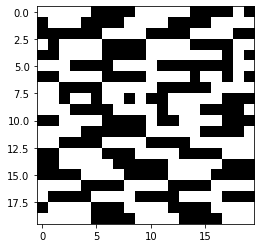

In [ ]:
bigan.train(dataset, epochs=10000000, batch_size=1, sample_interval=500, l_rate=0.0001)